In [1]:
import cv2
from matplotlib import pyplot as plt

In [2]:
plate_cascade_path = './haar_cascade_indian_license.xml'
plate_cascade = cv2.CascadeClassifier (plate_cascade_path)

In [3]:
def LicensePlate (image):
    roi = image.copy ()
    image_copy = image.copy ()
    plate_rectangle = plate_cascade.detectMultiScale (image, scaleFactor = 1.2, minNeighbors = 20)
    for x, y, w, h in plate_rectangle:
        region = roi[y:y + h, x:x + w, :]
        cv2.rectangle (image_copy, (x + 2,y), (x + w - 3, y + h - 5), (51, 181, 155), 3)
    
    return image_copy, region

In [4]:
bounded_image, roi = LicensePlate (cv2.imread ('./swift_plate_test.jpeg'))

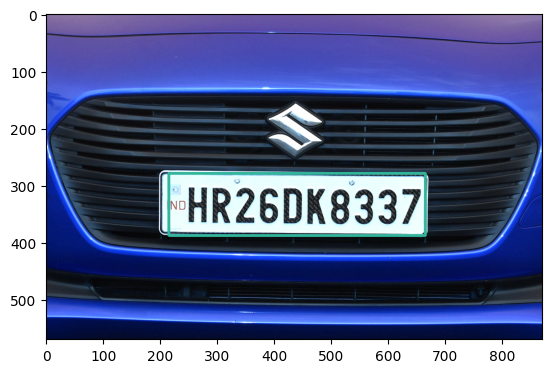

In [5]:
plt.imshow (bounded_image)

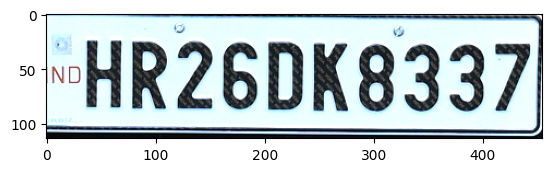

In [6]:
plt.imshow (roi)

In [7]:
import numpy as np

In [8]:
import pickle
from keras.models import load_model

with open ('./models/class_names.pkl', 'rb') as f:
    class_names = pickle.load (f) 

def NumberPlateToText (image) :
    image = cv2.cvtColor (cv2.resize (image, (333, 75)), cv2.COLOR_RGB2GRAY)

    min_intensity = 0 # change at the end
    max_intensity = 255 # change at the end
    min_pixel_value = np.min (image)
    max_pixel_value = np.max (image)
    enhanced_image = np.uint8 (((image - min_pixel_value) / (max_pixel_value - min_pixel_value)) * (max_intensity - min_intensity) + min_intensity)

    _, license_plate = cv2.threshold (enhanced_image, 200, 250, cv2.THRESH_OTSU)
    width = license_plate.shape[0]
    height = license_plate.shape[1]

    lower_bound_width, upper_bound_width, lower_bound_height, upper_bound_height = width / 6, width / 2, height / 10, height / 3
    contours, _ = cv2.findContours (license_plate.copy (), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted (contours, key=cv2.contourArea)[-15:]

    number_plate_positions = list ()
    number_plate_classifier = load_model ('./models/best.h5')

    curr_idx = 0
    fig, ax = plt.subplots (ncols=10, figsize=(20, 20))

    for contour in contours:
        X, Y, W, H = cv2.boundingRect (contour)

        if W > lower_bound_width and W < upper_bound_width and H > lower_bound_height and H < upper_bound_height:
            X -= 5 // 2  # Subtract half of the increase width from X
            Y -= 10 // 2  # Subtract half of the increase height from Y
            W += 5  # Add the increase width to the original width
            H += 10  # Add the increase height to the original height

            character = cv2.resize (image[Y:Y + H, X:X + W], (100, 75))
            image_to_classify = cv2.cvtColor (character, cv2.COLOR_GRAY2BGR)

            curr_idx += 1
            
            result_character = class_names[np.argmax (number_plate_classifier.predict (np.expand_dims (image_to_classify, 0)))]
            number_plate_positions.append ((result_character, X, image_to_classify.copy ()))

    number_plate_positions = sorted (number_plate_positions, key=lambda char: char[1])
    for i in range (10):
        ax[i].imshow (number_plate_positions[i][2])

    return ''.join ([char[0] for char in number_plate_positions])

2023-10-13 15:13:02.532610: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-10-13 15:13:02.532636: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-13 15:13:02.532640: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-13 15:13:02.532695: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-13 15:13:02.532716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-13 15:13:03.420502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 10ms/step


'HR 26 GK 8997'

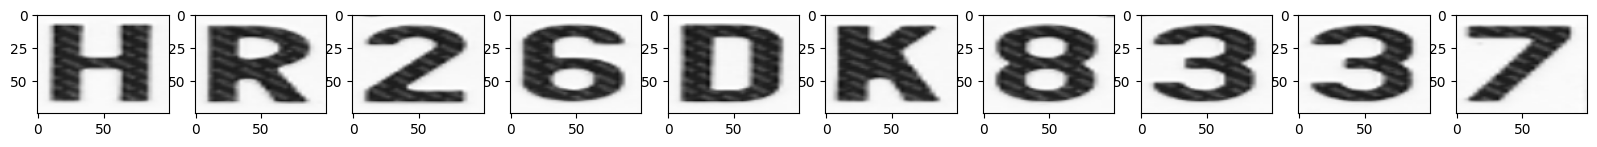

In [9]:
import re

re.sub (r'(?<=[a-zA-Z])(?=\d)|(?<=\d)(?=[a-zA-Z])', ' ', NumberPlateToText (roi))

In [10]:
# predictions could be better if we train the model with more data and more epochs